In [1]:
# we consider a least square problem, f(x) = (Ax-b)^2
import numpy as np
import numpy.linalg as la
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from math import sqrt


import warnings
warnings.filterwarnings("error")

In [197]:
def toy_abs(x, agent_num):
    gradient_x = np.zeros(x.shape)
    for i in range(agent_num):
        gradient_x[i,:] = np.sign(x[i,:]-i)
    return gradient_x
        
    
def toy_quad(x, agent_num):
    gradient_x = np.zeros(x.shape)
    for i in range(agent_num):
        gradient_x[i,:] = (x[i,:]-i)
    return gradient_x
        
def toy_power_4(x, agent_num):
    gradient_x = np.zeros(x.shape)
    for i in range(agent_num):
        gradient_x[i,:] = (x[i,:]-i)**3
    return gradient_x

In [198]:
np.random.seed(seed=42)
agent_num = 9

d=100
data_num = 20

In [183]:
# x_opt = np.ones((d))/d
x_opt = np.random.randn(d)+10
x_local_opt = np.tile(x_opt,(agent_num, 1))
x_local_opt = x_local_opt+  np.random.rand(agent_num, d)
# print(x_local_opt[:,0])
# P = ortho_group.rvs(d)
A = np.zeros((agent_num, data_num, d))
b = np.zeros((agent_num, data_num))

for i in range(agent_num):
    P = ortho_group.rvs(d)
    eigv = (np.random.rand(d))
    eigv[11:] = np.zeros(89)
    A_temp = np.matmul( np.diag(eigv), P)
    A[i] = A_temp[0:data_num,:]
# A = np.matmul(np.transpose(P), np.matmul( np.diag(eigv), P))
# x_opt = np.random.rand(d)
    b[i] = np.matmul( A[i], x_local_opt[i])
    
    
# filename = "d_1000_n_10"
# np.save(filename+"_A", A)
# np.save(filename+"_b", b)
# np.save(filename+"_x", x_opt)
print(np.linalg.matrix_rank(np.matmul(np.transpose(A[1]), A[1])))

11


In [184]:
# gamma = np.load("gamma.npy")

# # we first try to calculate the real optimal x_star
A_stack = np.reshape(A, (200,100))
b_stack = np.reshape(b, (200))

print(np.linalg.matrix_rank(np.matmul(np.transpose(A_stack), A_stack)))

# C = np.zeros((d,d-1))
# for i in range(d-1):
#     C[i,i] = 1
# C[d-1,:]=-1
# # print(C)
# A_prime = np.matmul(A_stack, C)

# c_vector = np.zeros((d))
# c_vector[-1]=1
# # print(c_vector)
# b_prime = b_stack - np.matmul(A_stack, c_vector)


# pinv_A = np.linalg.pinv(A_prime)
# x_temp = np.matmul(pinv_A, b_prime)
# x_direct = np.zeros((d))
# x_direct[:d-1] = x_temp
# x_direct[d-1] = 1 - np.sum(x_temp)
# print(x_direct[0])
# error = np.matmul(A_stack, x_direct)-b_stack
# loss_star = np.matmul(np.transpose(error), error)
# print(np.sum(loss_star))
pinv_A = np.linalg.pinv(A_stack)
x_direct = np.matmul(pinv_A, b_stack)
# print(x_direct[0])
error = np.matmul(A_stack, x_direct)-b_stack
loss_star = np.matmul(np.transpose(error), error)
plt.plot(x_direct)
print(np.min(x_direct))
print(loss_star)

ValueError: cannot reshape array of size 18000 into shape (200,100)

In [207]:
import time

x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 50000
lr = 1
time_int = 0.01

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

z_k = np.zeros((agent_num,d))
z_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))
# y_k2 = np.zeros((agent_num,d))
# x_accumulate = np.zeros((agent_num,d))
# y_accumulate = np.zeros((agent_num,d))


# z = np.zeros(d)
# loss_z = np.zeros((iter_num))
loss_x_global = np.zeros((agent_num, iter_num))
# accu_x_record = np.zeros((iter_num))
# accu_y_record = np.zeros((iter_num))
x_record = np.zeros((iter_num))
x_mean = np.zeros((iter_num,d))
loss = np.zeros((agent_num, iter_num))


lambda_0 = 0
lambda_k = 0
lambda_k1 = 0


# z = np.mean(x_0, axis = 0)
# for i in  range(agent_num):

#     x_k[i] = np.copy(x_0)
x_k = np.copy(x_0)
lambda_k = lambda_0
# 
z_k =  np.copy(x_k)

# z_k =  np.log(x_k)+1
# 
for k in tqdm(range( iter_num)):
    lambda_k1 = (1+np.sqrt(1+ 4*lambda_k**2))/2
    gamma = (1-lambda_k)/(lambda_k1)
    lambda_k = lambda_k1
    for i in range(agent_num):

        gradient_k1 = toy_power_4(x_k, agent_num)
        # print(gradient_k1)
        # gradient_k1 = np.matmul(np.transpose(A[i]), (np.matmul(A[i], x_k[i,:])-b[i]))
        y_k1[i,:] = y_k[i,:] + time_int*(x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:])
        # z_k1[i,:] = x_k[i,:] - time_int*(lr*gradient_k1[i,:]  - (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]))
        # x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:]
        # x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:]- time_int*( - y_k[i,:])
        
        
        z_k1[i,:] = x_k[i,:] - time_int*(lr*gradient_k1[i,:] - y_k[i,:] - (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]))
        # x_k1[i,:] = z_k1[i,:]
        x_k1[i,:] = (1-gamma)*z_k1[i,:] + gamma*z_k[i,:]
        # error = np.matmul(A[i], x_k1[i,:])-b[i]
        # loss[i, k] = np.matmul(np.transpose(error), error)
          
    z_k = np.copy(z_k1)
    x_k = np.copy(x_k1)
    y_k = np.copy(y_k1)
    
    temp_sum = 0
    x_bar = np.mean(x_k, axis=0)
    x_mean[k,:] = x_bar
    for agent in range(agent_num):
        temp_sum += np.linalg.norm(x_k[agent,:]-x_bar)
    x_record[k] = temp_sum/agent_num
    
    for i in range(agent_num):
#         print(x_k[i,:])
#         np.matmul(A_stack, )
        # error = np.matmul(A_stack, x_k[i,:])-b_stack
        error = 0
        for j in range(agent_num):
            
            # error += np.abs( x_k[i,:]-j)
            error += np.linalg.norm( x_k[i,:]-j)**4
        # loss_x_global[i,k] = np.matmul(np.transpose(error), error)
        loss_x_global[i,k] = error
#         if((loss_x_global[i,k]-loss_star)< 0.01):
#             print("reached")
#             reach=0
#             time.sleep(3600)



    

  0%|          | 0/50000 [00:00<?, ?it/s]

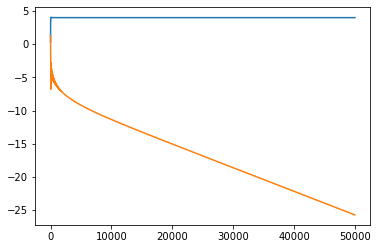

In [211]:
# plt.plot(np.log(np.abs(x_record-x_mean)))
plt.plot(x_mean[:,0])
plt.plot(np.log(np.abs(x_mean[:,0]-4)))
# plt.ylim(4,5)

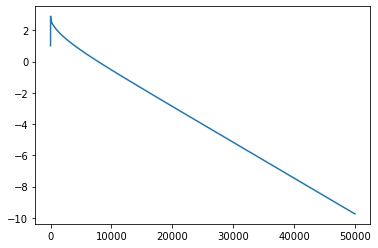

In [212]:
k_range = np.linspace(1, iter_num, iter_num)
# print(k_range)


# plt.plot(np.log(np.abs(k_range*(x_record-x_mean))))
plt.plot(np.log(np.abs((x_record))))


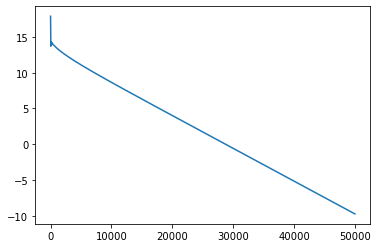

In [224]:
# loss_star = 20**2*d
loss_star = 0
for i in range(agent_num):
    loss_star += np.linalg.norm(4-i)**4*d**2


# plt.plot((k_range*k_range*np.abs(loss_x_global[2,:]-loss_star)))
plt.plot(np.log((loss_x_global[3,:]-loss_star)))
# plt.plot(((loss_x_global[4,:]-loss_star)))
# plt.ylim(0,1e7)

In [1]:
# # This is comparison in GD

# import time

# x_0 = np.random.rand(agent_num, d)

# #first is gradient Descent
# iter_num = 1000000
# lr = 1
# time_int = 0.01

# x_k = np.zeros((agent_num,d))
# x_k1 = np.zeros((agent_num,d))

# z_k = np.zeros((agent_num,d))
# z_k1 = np.zeros((agent_num,d))
# # x_k2 = np.zeros((agent_num,d))
# y_k = np.zeros((agent_num,d))
# y_k1 = np.zeros((agent_num,d))
# # y_k2 = np.zeros((agent_num,d))
# # x_accumulate = np.zeros((agent_num,d))
# # y_accumulate = np.zeros((agent_num,d))


# # z = np.zeros(d)
# # loss_z = np.zeros((iter_num))
# loss_x_global_GD = np.zeros((agent_num, iter_num))
# # accu_x_record = np.zeros((iter_num))
# # accu_y_record = np.zeros((iter_num))
# x_record = np.zeros((iter_num))
# x_mean = np.zeros((iter_num))
# loss_GD = np.zeros((agent_num, iter_num))

# # z = np.mean(x_0, axis = 0)
# # for i in  range(agent_num):

# #     x_k[i] = np.copy(x_0)
# x_k = np.copy(x_0)

# # 
# # z_k =  np.copy(x_k)

# # z_k =  np.log(x_k)+1
# # 
# for k in tqdm(range( iter_num)):
#     for i in range(agent_num):

#         gradient_k1 = np.matmul(np.transpose(A[i]), (np.matmul(A[i], x_k[i,:])-b[i]))
#         y_k1[i,:] = y_k[i,:] + time_int*(x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:])
# #         x_k1[i,:] = x_k[i,:] - time_int*(lr*gradient_k1 )
#         x_k1[i,:] = x_k[i,:] - time_int*(lr*gradient_k1 - y_k[i,:] - (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]))
#         error = np.matmul(A[i], x_k1[i,:])-b[i]
#         loss_GD[i, k] = np.matmul(np.transpose(error), error)
        
# #    change mirror method     
# #     for i in range(agent_num):
# #         x_k[i,:] = np.exp(z_k1[i,:])/np.exp(1)
# #         print(np.max(x_k[i,:]))
# #         x_k[i,:] = np.exp(z_k1[i,:])/sum(np.exp(z_k1[i,:]))
# #     
    
#     x_k = np.copy(x_k1)
#     y_k = np.copy(y_k1)

# #     z = np.mean(x_k, axis = 0)
# #     print(z[0])
# #     for i in range(agent_num):
# #     error = np.matmul(A_stack, z)-b_stack
# #     loss_z[k] = np.matmul(np.transpose(error), error)
#     temp_sum = 0
#     x_bar = np.mean(x_k, axis=0)
#     for agent in range(agent_num):
#         temp_sum += np.linalg.norm(x_k[agent,:]-x_bar)
#     x_record[k] = temp_sum/agent_num
#     for i in range(agent_num):
# #         print(x_k[i,:])
# #         np.matmul(A_stack, )
#         error = np.matmul(A_stack, x_k[i,:])-b_stack
#         loss_x_global_GD[i,k] = np.matmul(np.transpose(error), error)
# #         if((loss_x_global[i,k]-loss_star)< 0.01):
# #             print("reached")
# #             reach=0
# #             time.sleep(3600)



    

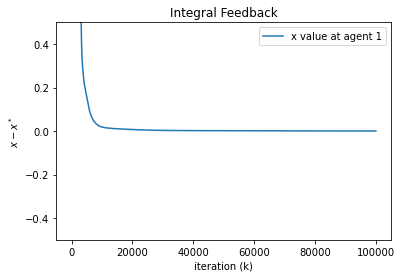

In [10]:
plt.plot(x_record, label='x value at agent 1')
# plt.plot(x_mean, label='x value of global average')
# plt.scatter(accu_x_record[1:])
# plt.plot(gamma[1:20000])
y_range = 0.5
plt.ylim((-y_range,y_range))

plt.xlabel('iteration (k)')
plt.ylabel('$x - x^*$')
# ax.annotate('', xy=(0.99, 0), ha='left', va='top', xycoords='axes fraction', fontsize=8)
plt.title("Integral Feedback")

plt.legend(loc='upper right')

# print(accu_x_record[-1])x_k[i,:]
# plt.xlabel("x_tilde value")
# plt.savefig("consensus_proposed")
# print(gamma[100000])

In [23]:
# plt.plot(x_record[1000000:])
# plt.plot(gamma[1:20000])
# plt.ylim((-5e10,5000000))
# print(x_record[-1])
# plt.xlabel("local x value")

# plt.savefig("non_accel_EXTRA x_record 5m_it over_k")

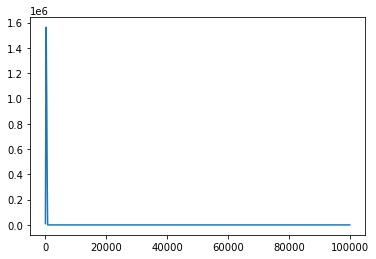

In [87]:
# loss_z_k2 = (loss_z-loss_star)*range(iter_num)*range(iter_num)
# loss_z_k1 = (loss_z-loss_star)*range(iter_num)
loss_star = 25**2*d
plt.plot((k_range*(loss_x_global[1,:]-loss_star)))
# plt.ylim((-0.01,0.05))
# print(loss_z_k2[1:].min())
# print((loss_z*range(iter_num))[-1])
# plt.xlabel("(loss-loss*)xk^2")
# plt.savefig("non_accel_EXTRA (loss-loss_star)k 5m_it over_k")
# loss_star_global
# plt.savefig("100k_simplex_loss")

In [8]:
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
for i in range(10):
    
#     loss_x_k2 = (loss_x_global[i,:]-loss_star)*range(iter_num)*range(iter_num)
    loss_x = (loss_x_global_GD[i,:]-loss_star)
#     loss_x_k2 = (loss_x_global[i,:])*range(iter_num)*range(iter_num)
#     loss_x_k2 = (loss_x_global[i,:]-loss_star)*range(iter_num)
    plt.plot(np.log(loss_x[1:]))
# loss_x2_k2 = (loss[1,:]-loss_star)*range(iter_num)*range(iter_num)
plt.xlabel('iteration (k)')
plt.ylabel('$log(loss - loss^*)$')

# plt.savefig("100k_simplex_log(local_loss-loss_star)")

# plt.plot(loss_x2_k2[1:])
# plt.ylim((0,1))
# print(loss_x_k2[1:].min())
# print(loss_z*range(30000)[-1])
# plt.xlabel("(loss-loss*)xk^2")


NameError: name 'loss_x_global_GD' is not defined

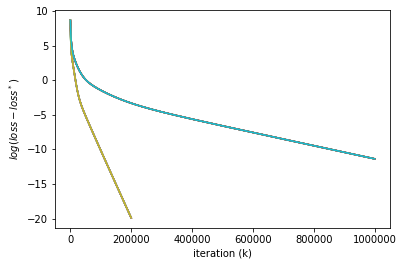

In [28]:
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
for i in range(10):
    
#     loss_x_k2 = (loss_x_global[i,:]-loss_star)*range(iter_num)*range(iter_num)
    loss_x1 = (loss_x_global[i,:]-loss_star)
    
#     loss_x_k2 = (loss_x_global[i,:])*range(iter_num)*range(iter_num)
#     loss_x_k2 = (loss_x_global[i,:]-loss_star)*range(iter_num)
    plt.plot(np.log(loss_x1[1:200000]))
    plt.plot(np.log(loss_x[1:]))
# loss_x2_k2 = (loss[1,:]-loss_star)*range(iter_num)*range(iter_num)
plt.xlabel('iteration (k)')
plt.ylabel('$log(loss - loss^*)$')

# plt.savefig("100k_simplex_log(local_loss-loss_star)")
plt.savefig("comparison_between_GD_MD")

# plt.plot(loss_x2_k2[1:])
# plt.ylim((0,1))
# print(loss_x_k2[1:].min())
# print(loss_z*range(30000)[-1])
# plt.xlabel("(loss-loss*)xk^2")


In [35]:
# np.save("100d_simplex_1m_loss", loss_x_global)
# np.save("100d_simplex_1m_loss_star", loss_star)
np.save("100d_simplex_1m_x_minus_bar", x_record)
# np.save(outfile, x)